# Nortek AD2CP Processing, Testing, and Data Exploration

jgradone@marine.rutgers.edu     01/11/2022    Initial

**This Jupyter Notebook is intended to:**<br>
1) Read glider data frome ERDDAP <br>
2) Read in AD2CP data processed to NetCDFs using the Nortek MIDAS software as an xarray DataSet and combine all into one massive DataSet <br>
3) Pull out just one glider segment (based on a unique file name) and the corresponding dead-reckoned depth average current. Use the start and end times to subset the AD2CP data <br>
4) Correct for local speed of sound <br>
5) QAQC AD2CP data <br>
6) Correct beams to level true-depth <br>
7) Bin map AD2CP data <br>
8) AD2CP Coordinate transformation from beam to XYZ to ENU <br>
9) Least squares linear inversion on ADCP velocities referenced to true ocean velocity through a depth averaged urrent constraint <br>
10) Save output from each segment<br>


*Details/comments on what the functions are actually doing in the source code*

In [28]:
# Imports
import scipy.interpolate as interp
from scipy.sparse.linalg import lsqr, lsmr
from scipy.sparse.linalg import inv
from scipy import integrate
import scipy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
import netCDF4 as nc
import math
import datetime
import xarray as xr
import matplotlib.dates as mdates
import dask.array as da
from erddapy import ERDDAP
from netCDF4 import Dataset
import gsw
#import cmocean.cm as cmo
import sys
from datetime import datetime
import time


## To import functions from Slocum-AD2CP GitHub repository, make this path the path to where the repo exists locally
sys.path.insert(0,'/home/jg1200/GitHub/Slocum-AD2CP/src/analysis/')
sys.path.insert(0,'/home/jg1200/GitHub/Slocum-AD2CP/src/data/')
sys.path.insert(0,'/home/jg1200/Code/Functions/loess/')
from make_dataset import correct_sound_speed, beam_true_depth, cell_vert, binmap_adcp, beam2enu, inversion, qaqc_pre_coord_transform, qaqc_post_coord_transform
from analysis import get_erddap_dataset
import loess_1d

## Set some plotting formats
plt.style.use('seaborn-poster')
myFmtshort = mdates.DateFormatter('%m/%d\n%H:%M')
myFmtlong = mdates.DateFormatter('%m/%d/%y \n%H:%M')
myFmt = mdates.DateFormatter('%m/%d/%y')

## Step 1: Load glider data

In [2]:
#ds_id = 'ru29-20210908T1943-trajectory-raw-delayed'
ds_id = 'ru29-20210630T1343-trajectory-raw-delayed'


## Load flight data
variables = ['depth', 'latitude', 'longitude', 'time', 'sci_water_temp', 'sci_water_cond','source_file', 'm_water_vx', 'm_water_vy', 'm_heading']
gdf = get_erddap_dataset(ds_id, server='http://slocum-data.marine.rutgers.edu/erddap', variables = variables, filetype='dataframe')
gdf.columns = variables

## Great way to find start and end times!!
start_times = gdf.groupby('source_file').first().time.values
end_times   = gdf.groupby('source_file').last().time.values
## Remove time zone for slicing ad2cp times
start_times2 = pd.to_datetime(start_times).tz_localize(None)
end_times2 = pd.to_datetime(end_times).tz_localize(None)

gdf

# x=10
# plt.plot(gdf.depth[(gdf.time >= start_times[x]) & (gdf.time <= end_times[x])])

,depth,latitude,longitude,time,sci_water_temp,sci_water_cond,source_file,m_water_vx,m_water_vy,m_heading
0,0.000000,18.170740,-64.831853,2021-06-30T13:43:52Z,0.0000,0.00000,ru29-2021-180-3-0-dbd(04570000),NaN,NaN,NaN
1,NaN,18.170740,-64.831853,2021-06-30T13:43:57Z,NaN,NaN,ru29-2021-180-3-0-dbd(04570000),-0.100307,0.03465,2.53247
2,0.000000,18.170740,-64.831853,2021-06-30T13:43:57Z,0.0000,0.00000,ru29-2021-180-3-0-dbd(04570000),NaN,NaN,NaN
3,NaN,18.170740,-64.831853,2021-06-30T13:44:54Z,NaN,NaN,ru29-2021-180-3-0-dbd(04570000),-0.100307,0.03465,2.53247
4,NaN,18.170465,-64.834150,2021-06-30T13:45:20Z,NaN,NaN,ru29-2021-180-3-0-dbd(04570000),NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
732984,0.238559,18.164417,-63.468548,2021-07-12T12:53:52Z,28.1624,5.63906,ru29-2021-192-0-9-dbd(04620009),NaN,NaN,NaN
732985,0.198799,18.164417,-63.468548,2021-07-12T12:53:54Z,28.1629,5.63894,ru29-2021-192-0-9-dbd(04620009),NaN,NaN,NaN
732986,0.178920,18.164417,-63.468548,2021-07-12T12:53:56Z,28.1619,5.63898,ru29-2021-192-0-9-dbd(04620009),NaN,NaN,NaN
732987,0.198799,18.164417,-63.468548,2021-07-12T12:53:58Z,28.1565,5.63899,ru29-2021-192-0-9-dbd(04620009),NaN,NaN,NaN


## Step 2: Load in AD2CP data frame

In [3]:
path = '/home/jg1200/Data/GliderData/RU29/RU29_2021_Mission_1_AD2CP_NC/'
#path = '/home/jg1200/Data/GliderData/RU29/RU29_2021_Mission_2_AD2CP_NC/'
files = np.sort(glob.glob(path+'*.nc'))

tot_ad2cp = xr.open_mfdataset(files,group='Data/Burst/', concat_dim="time", combine="nested")
## I think this is a documented bug in the xarray open_mfdataset function for grouped NetCDFs
config = xr.open_dataset(files[0],group='Config')
## So, just assigning the global attributes from the first file to the combined file
tot_ad2cp = tot_ad2cp.assign_attrs(config.attrs)
tot_ad2cp = tot_ad2cp.rename({'Velocity Range':'VelocityRange','Correlation Range':'CorrelationRange','Amplitude Range':'AmplitudeRange'})
# 2 House-keeping steps
# 1) Roll shifted 180 for some reason
tot_ad2cp['Roll'] = tot_ad2cp['Roll']-180
# 2) Surface depth is 10 meters. Needed for at least for the 2020 and both 2021 deployments, per conversations with Sven from Nortek.
tot_ad2cp['Pressure'] = tot_ad2cp['Pressure']-10
# Put time on x-dimension
tot_ad2cp = tot_ad2cp.transpose()
tot_ad2cp

<xarray.Dataset>
Dimensions:                    (time: 3752193, VelocityRange: 40, CorrelationRange: 40, AmplitudeRange: 40, Physicalbeam_dim: 4, AHRSRotationMatrix_dim: 9)
Coordinates:
  * time                       (time) datetime64[ns] 2021-07-09T01:36:06.9070...
  * VelocityRange              (VelocityRange) float32 0.7 1.2 1.7 ... 19.7 20.2
  * CorrelationRange           (CorrelationRange) float32 0.7 1.2 ... 19.7 20.2
  * AmplitudeRange             (AmplitudeRange) float32 0.7 1.2 ... 19.7 20.2
Dimensions without coordinates: Physicalbeam_dim, AHRSRotationMatrix_dim
Data variables: (12/52)
    VelocityBeam1              (VelocityRange, time) float32 dask.array<chunksize=(40, 22049), meta=np.ndarray>
    VelocityBeam2              (VelocityRange, time) float32 dask.array<chunksize=(40, 22049), meta=np.ndarray>
    VelocityBeam3              (VelocityRange, time) float32 dask.array<chunksize=(40, 22049), meta=np.ndarray>
    VelocityBeam4              (VelocityRange, time) float32 dask.array<chunksize=(40, 22049), meta=np.ndarray>
    CorrelationBeam1           (CorrelationRange, time) float32 dask.array<chunksize=(40, 22049), meta=np.ndarray>
    CorrelationBeam2           (CorrelationRange, time) float32 dask.array<chunksize=(40, 22049), meta=np.ndarray>
    ...                         ...
    QuaternionX                (time) float32 dask.array<chunksize=(22049,), meta=np.ndarray>
    QuaternionY                (time) float32 dask.array<chunksize=(22049,), meta=np.ndarray>
    QuaternionZ                (time) float32 dask.array<chunksize=(22049,), meta=np.ndarray>
    AHRSGyroX                  (time) float32 dask.array<chunksize=(22049,), meta=np.ndarray>
    AHRSGyroY                  (time) float32 dask.array<chunksize=(22049,), meta=np.ndarray>
    AHRSGyroZ                  (time) float32 dask.array<chunksize=(22049,), meta=np.ndarray>
Attributes: (12/350)
    exportRevision:                               4421
    File_ins_runTime:                             96653500.0
    File_ins_runTime_description:                 Length of time data was col...
    File_ins_name:                                AD2CPRaw
    File_ins_name_description:                    Name of instrument
    File_ins_typeName:                            
    ...                                           ...
    instrumentOffsetTime:                         0.0
    instrumentOffsetTime_description:             Offset from instrument time...
    timeZoneOffset:                               -18000
    timeZoneOffset_description:                   Offset of platform local ti...
    instrumentOffsetTimeMatlab:                   0.0
    instrumentOffsetTimeMatlab_description:       Offset from instrument time...

## Step 3: Subset datasets
Pull out just one glider segment (based on a unique file name) and the corresponding dead-reckoned depth average current. Use the start and end times to subset the AD2CP data

In [4]:
## Just one file for testing
#x = -2 ## Good single 500 meter dive
#x=141 ## Good single 1000 meter dive
x=154


## Subset glider df to one segment
subsetgdf = gdf[(gdf.time >= start_times[x]) & (gdf.time <= end_times[x])]
## Pull out last non-NaN DAC
ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()
vx          = subsetgdf.m_water_vx.iloc[ind[-1]]
vy          = subsetgdf.m_water_vy.iloc[ind[-1]]
vx_lon      = np.nanmean(subsetgdf.longitude)
vx_lat      = np.nanmean(subsetgdf.latitude)
vx_start_tm = subsetgdf.time.iloc[0]
vx_end_tm   = subsetgdf.time.iloc[-1]

## Subset AD2CP dataframe based on segment start and end times
ad2cp_time_ind = np.where((tot_ad2cp.time >= start_times2[x]) & (tot_ad2cp.time <= end_times2[x]))[0]
subset_ad2cp = tot_ad2cp.sel(time=tot_ad2cp.time[ad2cp_time_ind])

## Take a quick peak at some data

/tmp/ipykernel_34270/2703616999.py:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(x,-by,subset_ad2cp['AmplitudeBeam1'])


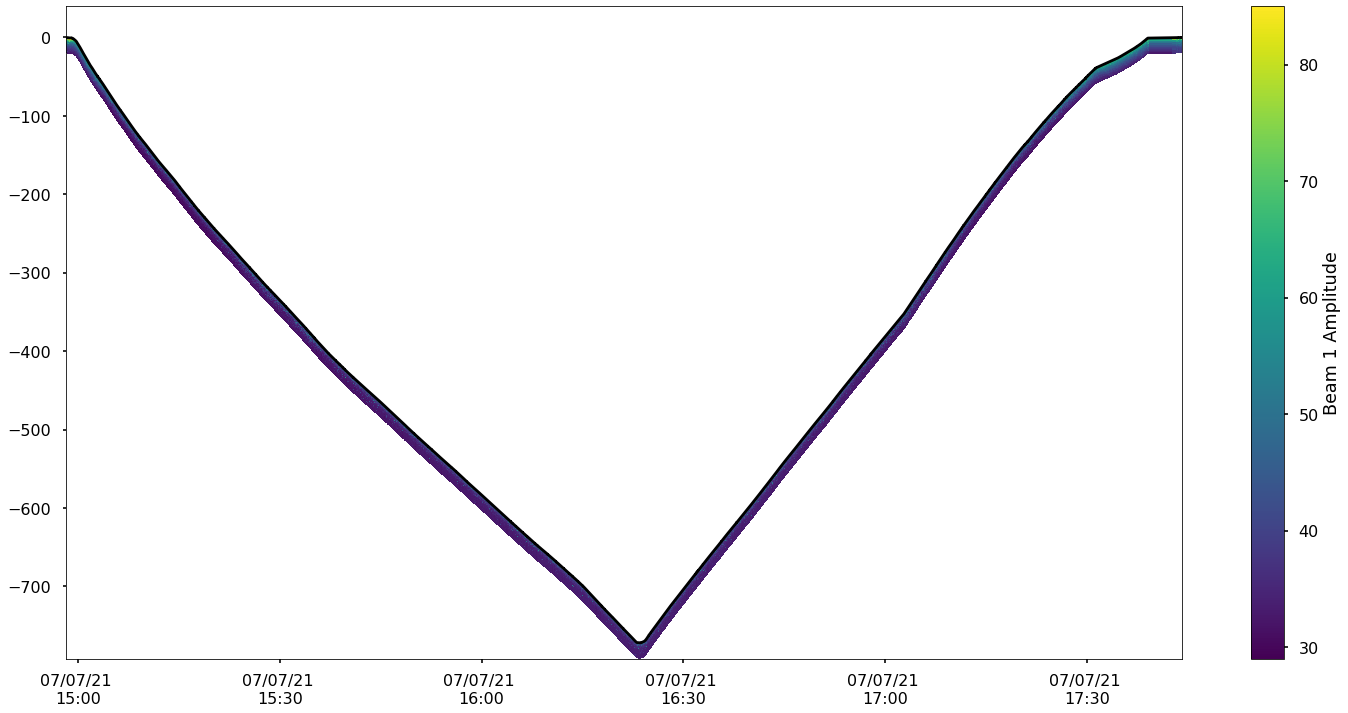

In [5]:
[x,y]=np.meshgrid(subset_ad2cp['time'],subset_ad2cp['VelocityRange'])
[bdepth,bbins]=np.meshgrid(subset_ad2cp['Pressure'],subset_ad2cp['VelocityRange'])

by=bdepth+bbins

fig = plt.figure(figsize=(25,12))

plt.pcolormesh(x,-by,subset_ad2cp['AmplitudeBeam1'])
plt.plot(subset_ad2cp['time'],-subset_ad2cp['Pressure'],'k')
plt.colorbar(label='Beam 1 Amplitude')
plt.gca().xaxis.set_major_formatter(myFmtlong)

### Zoomed in peak at data

/tmp/ipykernel_34270/4140484901.py:10: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(x[:,start_ind:end_ind],-by[:,start_ind:end_ind],subset_ad2cp['VelocityBeam1'][:,start_ind:end_ind])


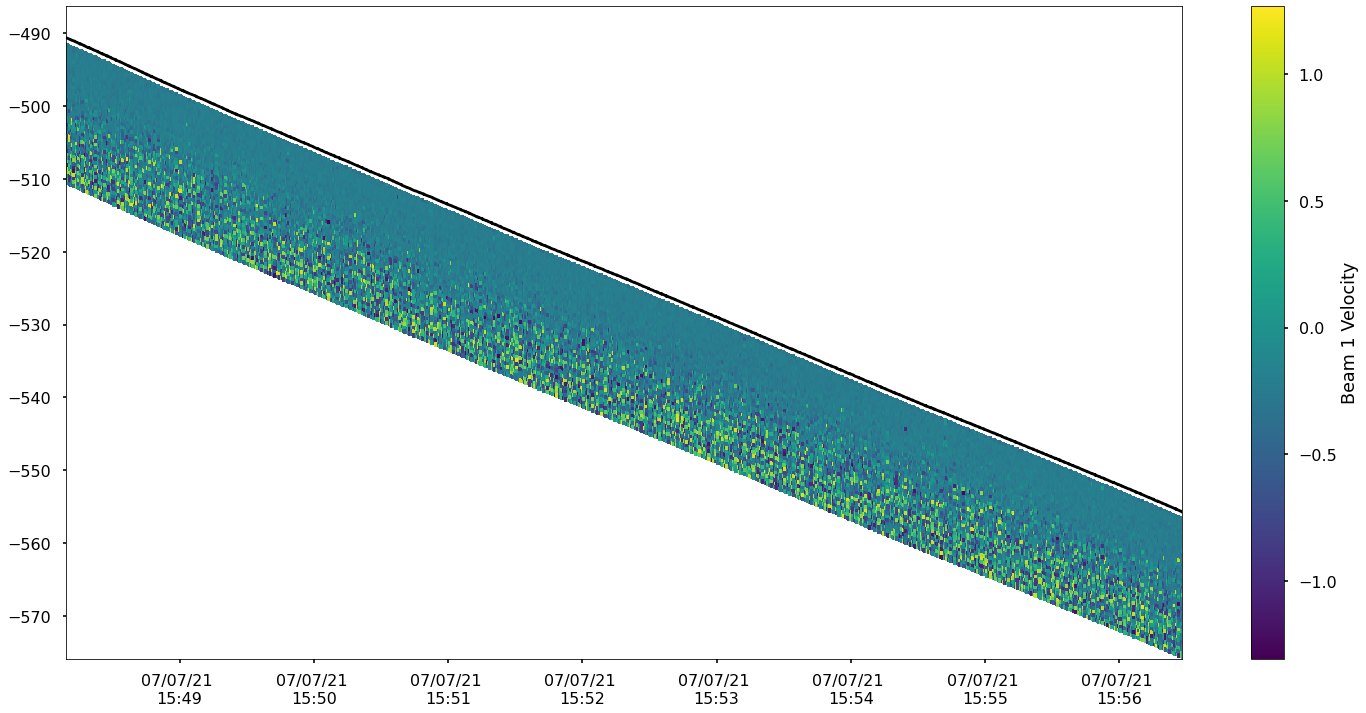

In [6]:
[x,y]=np.meshgrid(subset_ad2cp['time'],subset_ad2cp['VelocityRange'])
[bdepth,bbins]=np.meshgrid(subset_ad2cp['Pressure'],subset_ad2cp['VelocityRange'])

by=bdepth+bbins

start_ind = 12000
end_ind   = 14000

fig = plt.figure(figsize=(25,12))
plt.pcolormesh(x[:,start_ind:end_ind],-by[:,start_ind:end_ind],subset_ad2cp['VelocityBeam1'][:,start_ind:end_ind])
plt.plot(subset_ad2cp['time'][start_ind:end_ind],-subset_ad2cp['Pressure'][start_ind:end_ind],'k')
plt.colorbar(label='Beam 1 Velocity')
plt.gca().xaxis.set_major_formatter(myFmtlong)

## Step 4: Correct for local speed of sound (Fischer and Visbeck, 1993)
Where C is the real sound speed at the transducer, and CA is the speed of sound used by the ADCP. CA used by the Nortek AD2CP is 1500 m/s.

In [7]:
np.max(subset_ad2cp.VelocityBeam1.values)

1.323

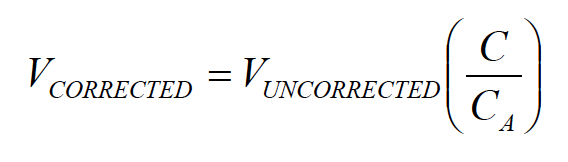

In [8]:
## Correct for local speed of sound
subset_ad2cp = correct_sound_speed(subset_ad2cp)

In [9]:
np.max(subset_ad2cp.VelocityBeam1.values)

1.3310262

### Take a peak at the speed of sound corrected data

/tmp/ipykernel_34270/4140484901.py:10: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(x[:,start_ind:end_ind],-by[:,start_ind:end_ind],subset_ad2cp['VelocityBeam1'][:,start_ind:end_ind])


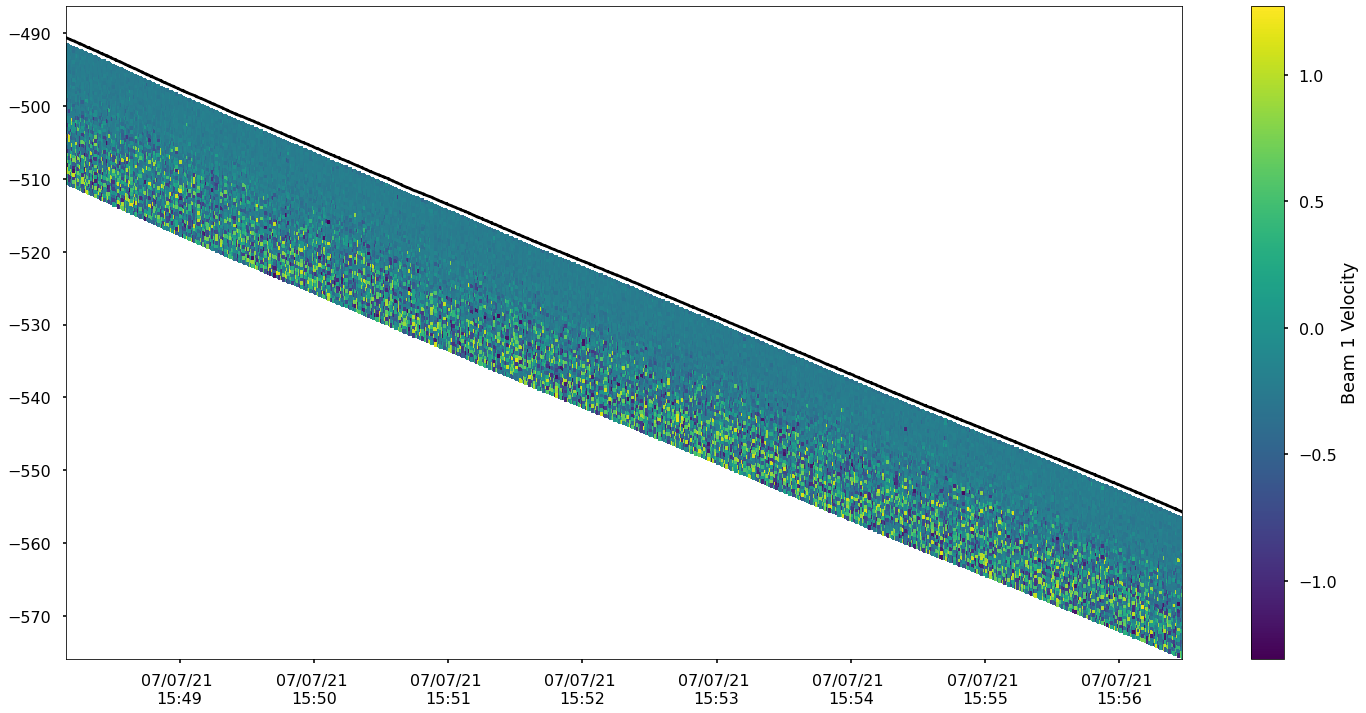

In [10]:
[x,y]=np.meshgrid(subset_ad2cp['time'],subset_ad2cp['VelocityRange'])
[bdepth,bbins]=np.meshgrid(subset_ad2cp['Pressure'],subset_ad2cp['VelocityRange'])

by=bdepth+bbins

start_ind = 12000
end_ind   = 14000

fig = plt.figure(figsize=(25,12))
plt.pcolormesh(x[:,start_ind:end_ind],-by[:,start_ind:end_ind],subset_ad2cp['VelocityBeam1'][:,start_ind:end_ind])
plt.plot(subset_ad2cp['time'][start_ind:end_ind],-subset_ad2cp['Pressure'][start_ind:end_ind],'k')
plt.colorbar(label='Beam 1 Velocity')
plt.gca().xaxis.set_major_formatter(myFmtlong)

## Step 5: Filter for Extreme Amplitude Returns and Below 0.5 Correlation (Todd et al. 2017)

In [11]:
np.nanmean(subset_ad2cp.VelocityBeam1.values)

-0.20378765

In [12]:
## QAQC pre-coordinate transformation
subset_ad2cp = qaqc_pre_coord_transform(subset_ad2cp)

In [13]:
np.nanmean(subset_ad2cp.VelocityBeam1.values)

-0.23767386

### Take a peak at the QAQC'd data

/tmp/ipykernel_34270/1563067960.py:14: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(x[:,start_ind:end_ind],-by[:,start_ind:end_ind],subset_ad2cp['CorrelationBeam1'][:,start_ind:end_ind])


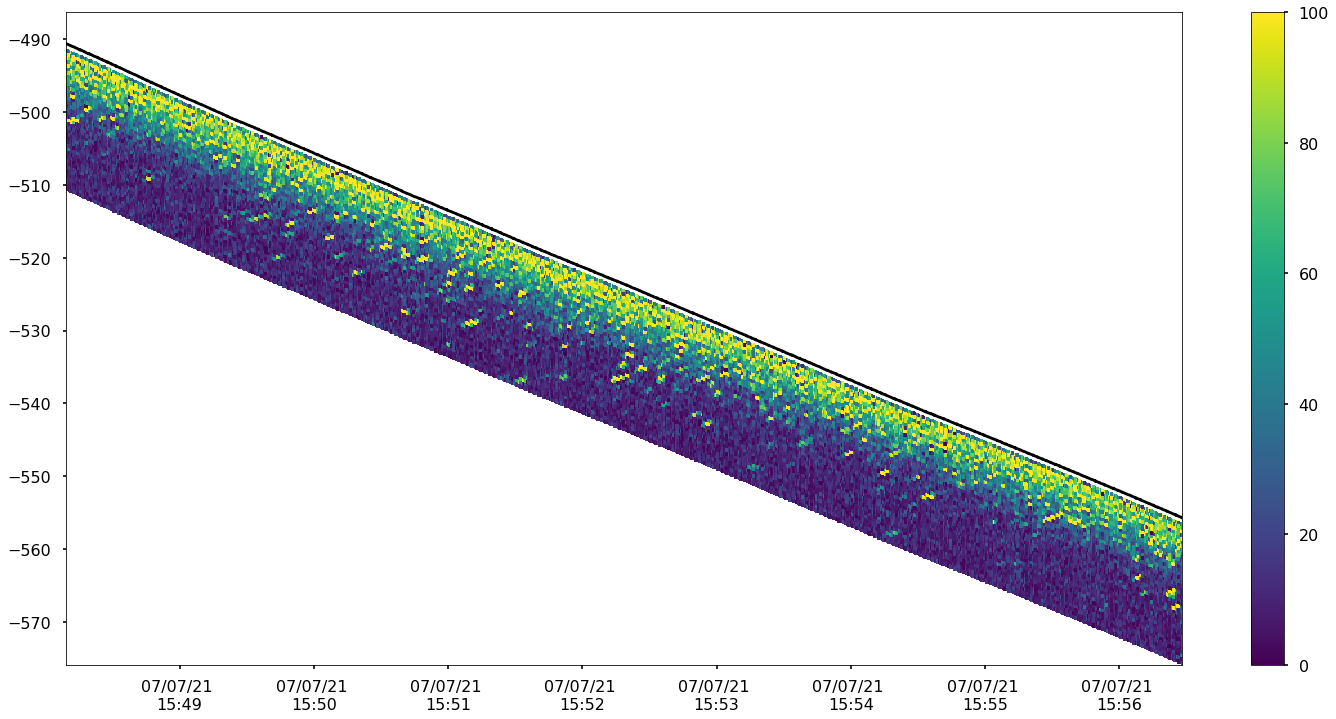

In [14]:
[x,y]=np.meshgrid(subset_ad2cp['time'],subset_ad2cp['VelocityRange'])
[bdepth,bbins]=np.meshgrid(subset_ad2cp['Pressure'],subset_ad2cp['VelocityRange'])

by=bdepth+bbins

# start_ind = 500
# end_ind   = 850

start_ind = 12000
end_ind   = 14000


fig = plt.figure(figsize=(25,12))
plt.pcolormesh(x[:,start_ind:end_ind],-by[:,start_ind:end_ind],subset_ad2cp['CorrelationBeam1'][:,start_ind:end_ind])
plt.plot(subset_ad2cp['time'][start_ind:end_ind],-subset_ad2cp['Pressure'][start_ind:end_ind],'k')
plt.colorbar()
#plt.colorbar(label='Beam 1 Correlation')
plt.gca().xaxis.set_major_formatter(myFmtlong)

/tmp/ipykernel_34270/4140484901.py:10: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(x[:,start_ind:end_ind],-by[:,start_ind:end_ind],subset_ad2cp['VelocityBeam1'][:,start_ind:end_ind])


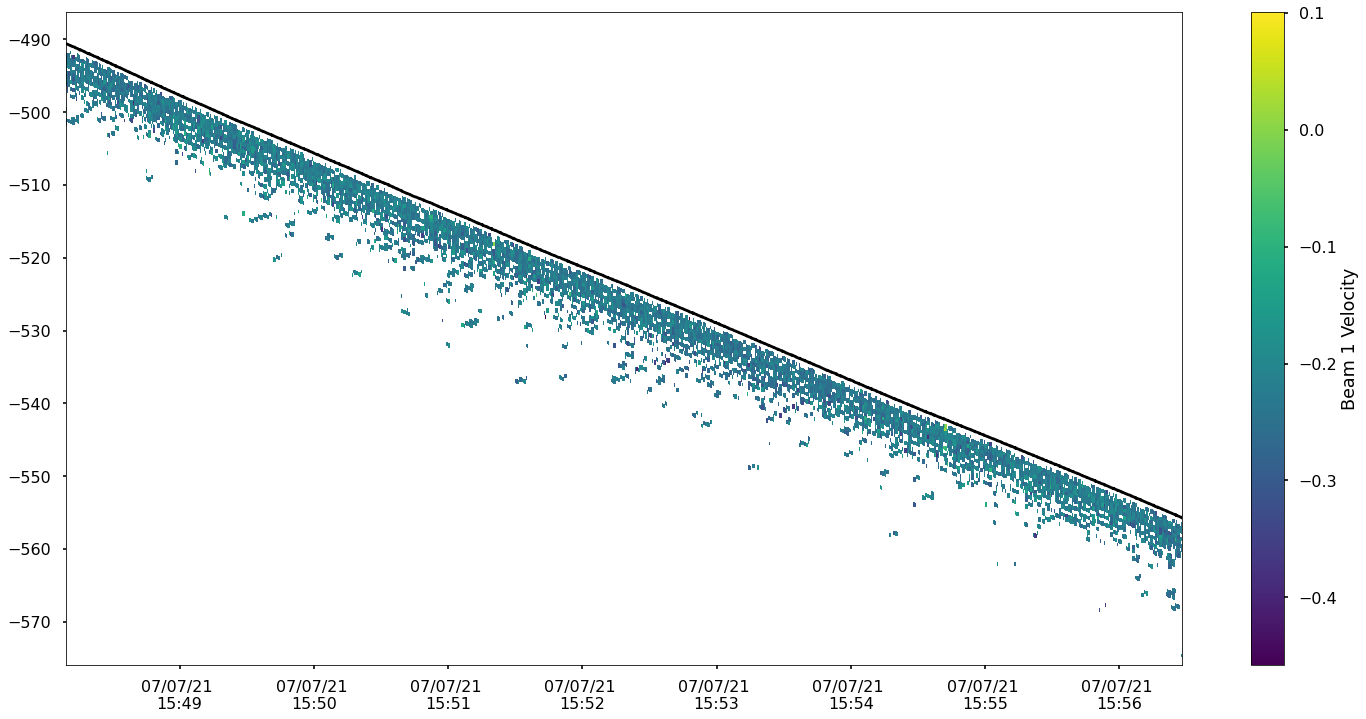

In [15]:
[x,y]=np.meshgrid(subset_ad2cp['time'],subset_ad2cp['VelocityRange'])
[bdepth,bbins]=np.meshgrid(subset_ad2cp['Pressure'],subset_ad2cp['VelocityRange'])

by=bdepth+bbins

start_ind = 12000
end_ind   = 14000

fig = plt.figure(figsize=(25,12))
plt.pcolormesh(x[:,start_ind:end_ind],-by[:,start_ind:end_ind],subset_ad2cp['VelocityBeam1'][:,start_ind:end_ind])
plt.plot(subset_ad2cp['time'][start_ind:end_ind],-subset_ad2cp['Pressure'][start_ind:end_ind],'k')
plt.colorbar(label='Beam 1 Velocity')
plt.gca().xaxis.set_major_formatter(myFmtlong)

## Processing Step 6: Correct beams to level true-depth

In [16]:
## Correct beams to level true-depth
subset_ad2cp = beam_true_depth(subset_ad2cp)

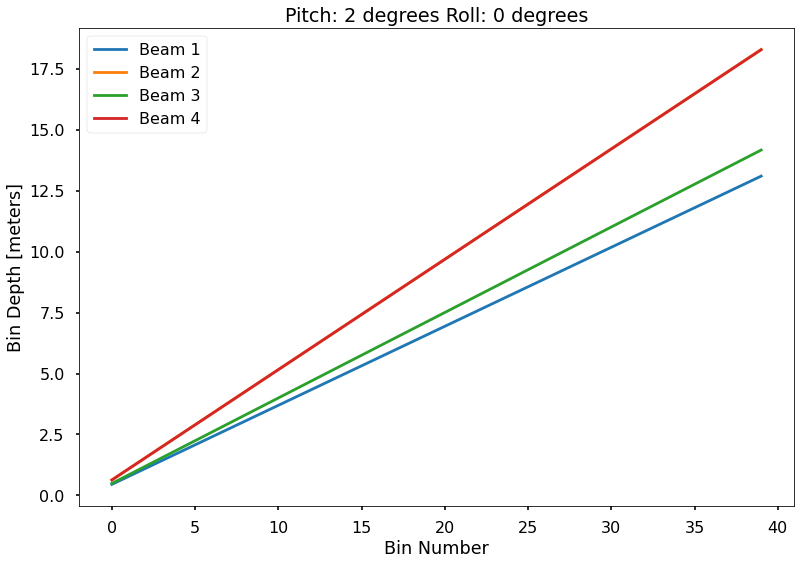

In [17]:
x=20
plt.plot(subset_ad2cp.TrueDepthBeam1.values[:,x],label='Beam 1')
plt.plot(subset_ad2cp.TrueDepthBeam2.values[:,x],label='Beam 2')
plt.plot(subset_ad2cp.TrueDepthBeam3.values[:,x],label='Beam 3')
plt.plot(subset_ad2cp.TrueDepthBeam4.values[:,x],label='Beam 4')
plt.ylabel('Bin Depth [meters]')
plt.xlabel('Bin Number')
plt.title('Pitch: %i' %subset_ad2cp['Pitch'].values[x] + ' degrees Roll: %i' %subset_ad2cp['Roll'].values[x] + ' degrees')
plt.legend()

## Processing Step 7: Bin Mapping
Interpolate to set depth grid, this will also effectively filter out extreme pitch and roll

In [18]:
## Bin map
subset_ad2cp = binmap_adcp(subset_ad2cp)

In [19]:
subset_ad2cp

<xarray.Dataset>
Dimensions:                    (time: 38835, VelocityRange: 40, CorrelationRange: 40, AmplitudeRange: 40, Physicalbeam_dim: 4, AHRSRotationMatrix_dim: 9)
Coordinates:
  * time                       (time) datetime64[ns] 2021-07-07T14:58:09.0320...
  * VelocityRange              (VelocityRange) float32 0.7 1.2 1.7 ... 19.7 20.2
  * CorrelationRange           (CorrelationRange) float32 0.7 1.2 ... 19.7 20.2
  * AmplitudeRange             (AmplitudeRange) float32 0.7 1.2 ... 19.7 20.2
Dimensions without coordinates: Physicalbeam_dim, AHRSRotationMatrix_dim
Data variables: (12/61)
    VelocityBeam1              (VelocityRange, time) float32 -0.1933 ... nan
    VelocityBeam2              (VelocityRange, time) float32 -0.1953 ... nan
    VelocityBeam3              (VelocityRange, time) float32 0.08224 ... nan
    VelocityBeam4              (VelocityRange, time) float32 -0.11 ... nan
    CorrelationBeam1           (CorrelationRange, time) float32 dask.array<chunksize=(40, 12296), meta=np.ndarray>
    CorrelationBeam2           (CorrelationRange, time) float32 dask.array<chunksize=(40, 12296), meta=np.ndarray>
    ...                         ...
    TrueDepthBeam4             (VelocityRange, time) float64 -0.6344 ... 18.37
    TrueDepth                  (VelocityRange, time) float64 1.012 ... 20.44
    InterpVelocityBeam1        (VelocityRange, time) float64 nan nan ... nan nan
    InterpVelocityBeam2        (VelocityRange, time) float64 nan nan ... nan nan
    InterpVelocityBeam3        (VelocityRange, time) float64 nan nan ... nan nan
    InterpVelocityBeam4        (VelocityRange, time) float64 nan nan ... nan nan
Attributes: (12/350)
    exportRevision:                               4421
    File_ins_runTime:                             96653500.0
    File_ins_runTime_description:                 Length of time data was col...
    File_ins_name:                                AD2CPRaw
    File_ins_name_description:                    Name of instrument
    File_ins_typeName:                            
    ...                                           ...
    instrumentOffsetTime:                         0.0
    instrumentOffsetTime_description:             Offset from instrument time...
    timeZoneOffset:                               -18000
    timeZoneOffset_description:                   Offset of platform local ti...
    instrumentOffsetTimeMatlab:                   0.0
    instrumentOffsetTimeMatlab_description:       Offset from instrument time...

### Take a peak at the bin mapped data

/tmp/ipykernel_34270/2288300711.py:10: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(x[:,start_ind:end_ind],-by[:,start_ind:end_ind],subset_ad2cp['InterpVelocityBeam1'][:,start_ind:end_ind])


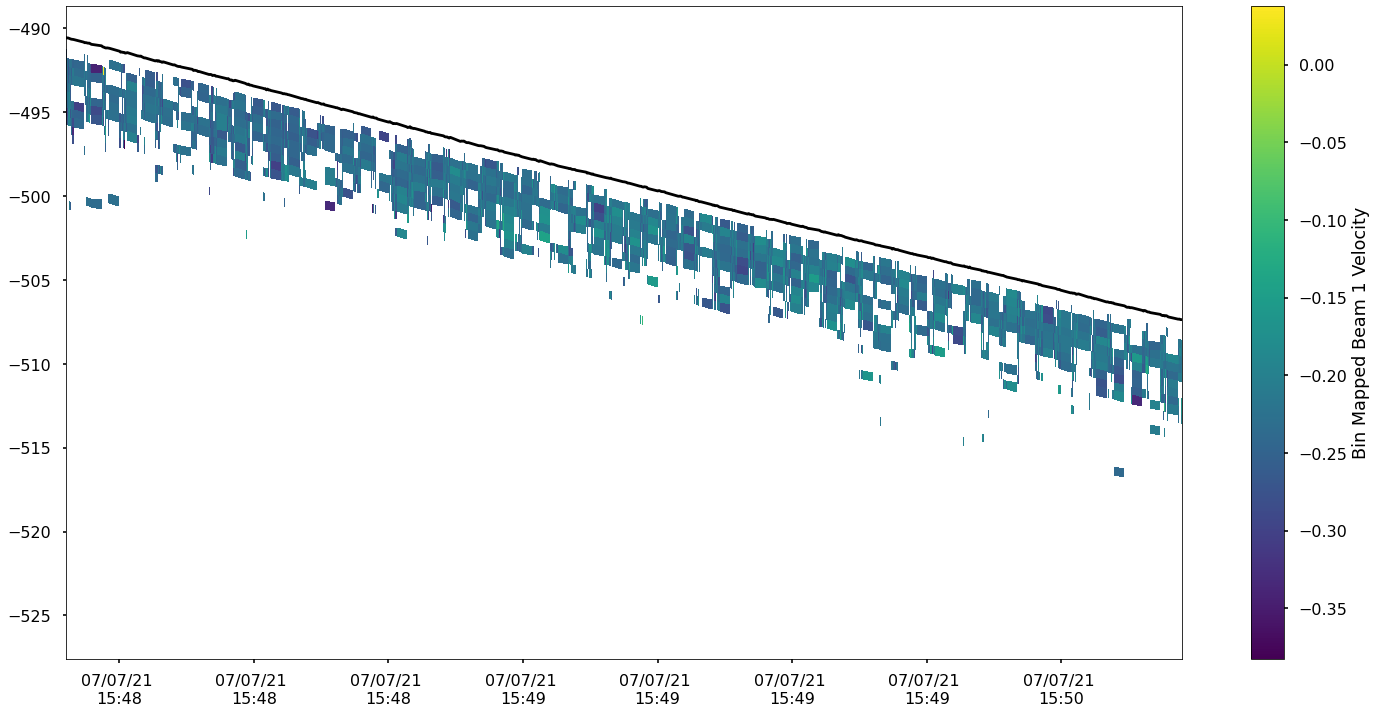

In [20]:
[x,y]=np.meshgrid(subset_ad2cp['time'],subset_ad2cp['VelocityRange'])
[bdepth,bbins]=np.meshgrid(subset_ad2cp['Pressure'],subset_ad2cp['VelocityRange'])

by=bdepth+bbins

start_ind = 12000
end_ind   = 12500

fig = plt.figure(figsize=(25,12))
plt.pcolormesh(x[:,start_ind:end_ind],-by[:,start_ind:end_ind],subset_ad2cp['InterpVelocityBeam1'][:,start_ind:end_ind])
plt.plot(subset_ad2cp['time'][start_ind:end_ind],-subset_ad2cp['Pressure'][start_ind:end_ind],'k')
plt.colorbar(label='Bin Mapped Beam 1 Velocity')
plt.gca().xaxis.set_major_formatter(myFmtlong)

## Processing Step 8: Convert from Beam to XYZ to ENU coordinates

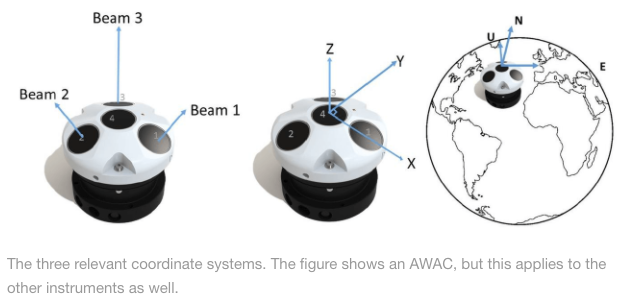

In [21]:
## Beam to ENU
subset_ad2cp = beam2enu(subset_ad2cp)

### Take a peak at ENU data

/tmp/ipykernel_34270/2605771011.py:23: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(x[:,start_ind:end_ind],-by[:,start_ind:end_ind],subset_ad2cp['VVelocity'][:,start_ind:end_ind])


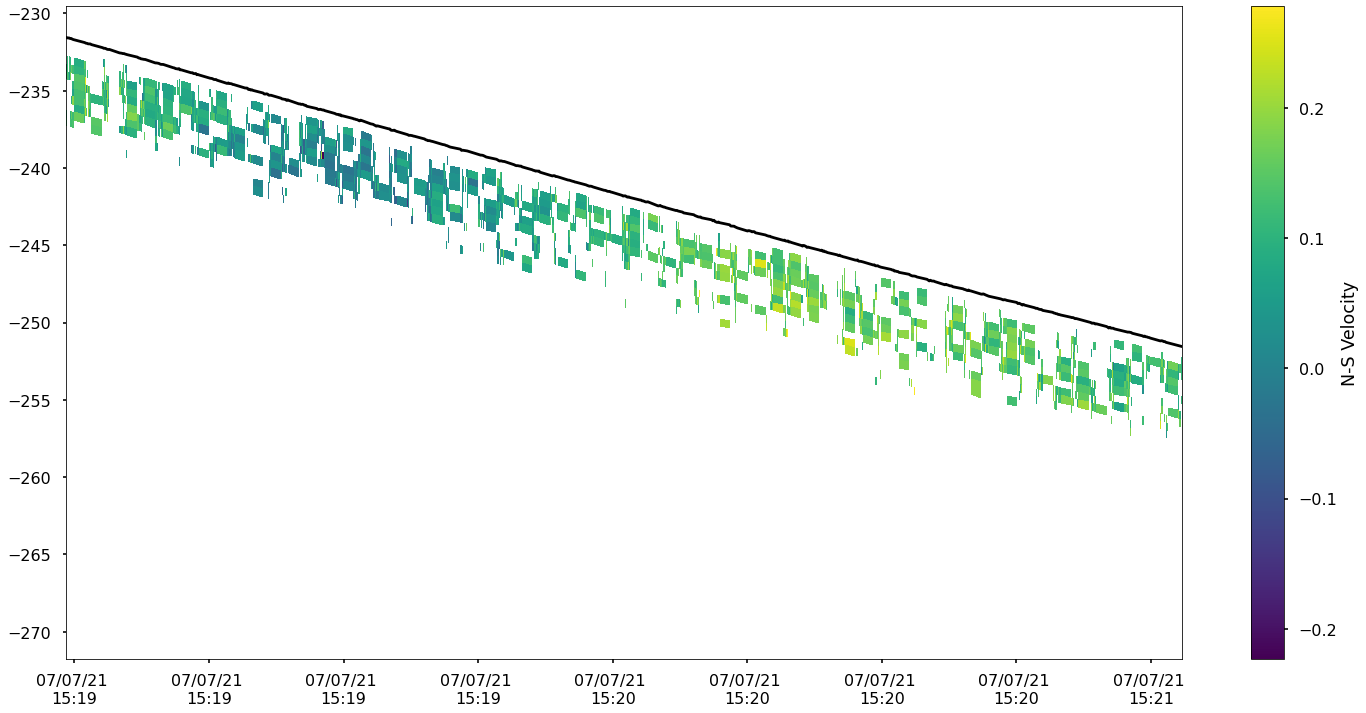

In [22]:
[x,y]=np.meshgrid(subset_ad2cp['time'],subset_ad2cp['VelocityRange'])
[bdepth,bbins]=np.meshgrid(subset_ad2cp['Pressure'],subset_ad2cp['VelocityRange'])

by=bdepth+bbins


# start_ind = 200
# end_ind   = 850

start_ind = 5000
end_ind   = 5500

# start_ind = 8060
# end_ind   = 8300

# start_ind = 14040
# end_ind   = 14300

# start_ind = 24800
# end_ind   = 25000

fig = plt.figure(figsize=(25,12))
plt.pcolormesh(x[:,start_ind:end_ind],-by[:,start_ind:end_ind],subset_ad2cp['VVelocity'][:,start_ind:end_ind])
plt.plot(subset_ad2cp['time'][start_ind:end_ind],-subset_ad2cp['Pressure'][start_ind:end_ind],'k')
plt.colorbar(label='N-S Velocity')
plt.gca().xaxis.set_major_formatter(myFmtlong)

/tmp/ipykernel_34270/3852730933.py:23: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(x[:,start_ind:end_ind],-by[:,start_ind:end_ind],subset_ad2cp['UVelocity'][:,start_ind:end_ind])


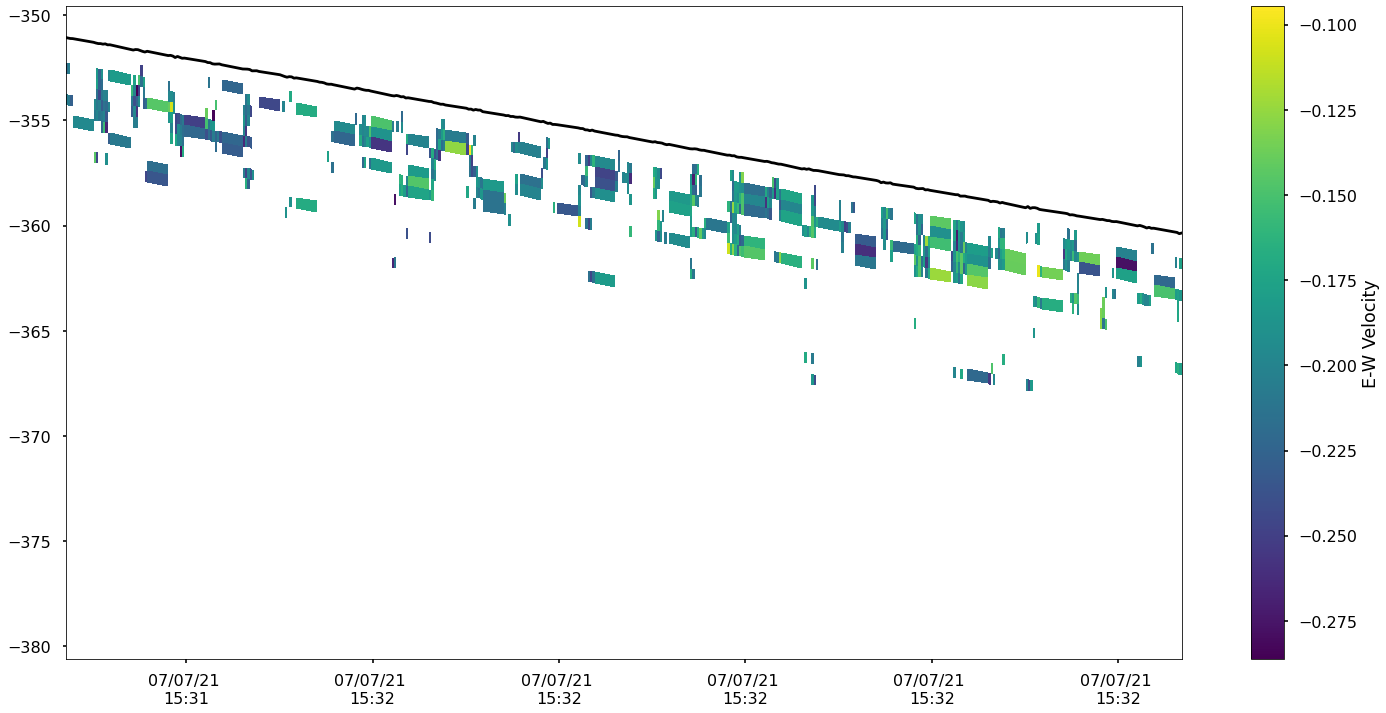

In [23]:
[x,y]=np.meshgrid(subset_ad2cp['time'],subset_ad2cp['VelocityRange'])
[bdepth,bbins]=np.meshgrid(subset_ad2cp['Pressure'],subset_ad2cp['VelocityRange'])

by=bdepth+bbins


# start_ind = 200
# end_ind   = 850

# start_ind = 800
# end_ind   = 1500

start_ind = 8060
end_ind   = 8300

# start_ind = 14040
# end_ind   = 14300

# start_ind = 24800
# end_ind   = 25000

fig = plt.figure(figsize=(25,12))
plt.pcolormesh(x[:,start_ind:end_ind],-by[:,start_ind:end_ind],subset_ad2cp['UVelocity'][:,start_ind:end_ind])
plt.plot(subset_ad2cp['time'][start_ind:end_ind],-subset_ad2cp['Pressure'][start_ind:end_ind],'k')
plt.colorbar(label='E-W Velocity')
plt.gca().xaxis.set_major_formatter(myFmtlong)

/tmp/ipykernel_34270/1668302072.py:20: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(x[:,start_ind:end_ind],-by[:,start_ind:end_ind],subset_ad2cp['VVelocity'][:,start_ind:end_ind])


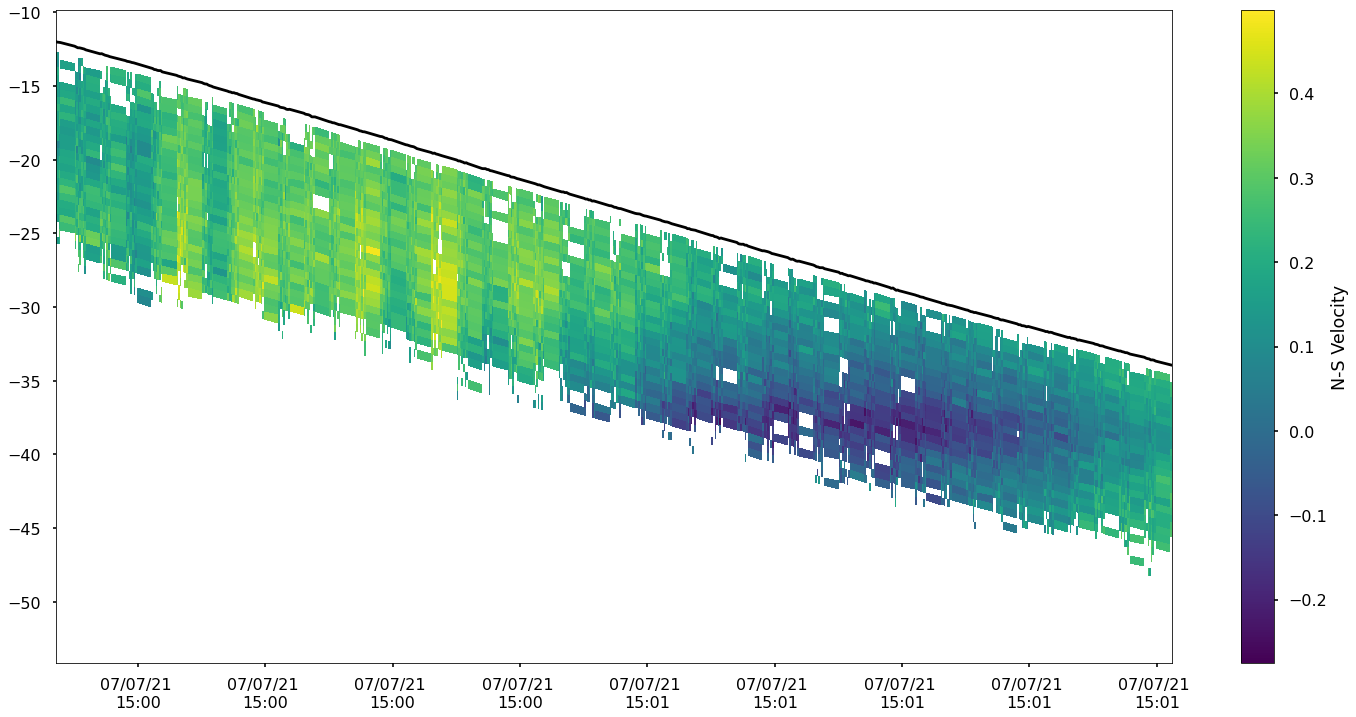

In [24]:
[x,y]=np.meshgrid(subset_ad2cp['time'],subset_ad2cp['VelocityRange'])
[bdepth,bbins]=np.meshgrid(subset_ad2cp['Pressure'],subset_ad2cp['VelocityRange'])

by=bdepth+bbins

start_ind = 500
end_ind   = 850

# start_ind = 8060
# end_ind   = 8300

# start_ind = 14040
# end_ind   = 14300

# start_ind = 24800
# end_ind   = 25000


fig = plt.figure(figsize=(25,12))
plt.pcolormesh(x[:,start_ind:end_ind],-by[:,start_ind:end_ind],subset_ad2cp['VVelocity'][:,start_ind:end_ind])
plt.plot(subset_ad2cp['time'][start_ind:end_ind],-subset_ad2cp['Pressure'][start_ind:end_ind],'k')
plt.colorbar(label='N-S Velocity')
plt.gca().xaxis.set_major_formatter(myFmtlong)

In [25]:
subset_ad2cp

<xarray.Dataset>
Dimensions:                    (time: 38835, VelocityRange: 40, CorrelationRange: 40, AmplitudeRange: 40, Physicalbeam_dim: 4, AHRSRotationMatrix_dim: 9)
Coordinates:
  * time                       (time) datetime64[ns] 2021-07-07T14:58:09.0320...
  * VelocityRange              (VelocityRange) float32 0.7 1.2 1.7 ... 19.7 20.2
  * CorrelationRange           (CorrelationRange) float32 0.7 1.2 ... 19.7 20.2
  * AmplitudeRange             (AmplitudeRange) float32 0.7 1.2 ... 19.7 20.2
Dimensions without coordinates: Physicalbeam_dim, AHRSRotationMatrix_dim
Data variables: (12/64)
    VelocityBeam1              (VelocityRange, time) float32 -0.1933 ... nan
    VelocityBeam2              (VelocityRange, time) float32 -0.1953 ... nan
    VelocityBeam3              (VelocityRange, time) float32 0.08224 ... nan
    VelocityBeam4              (VelocityRange, time) float32 -0.11 ... nan
    CorrelationBeam1           (CorrelationRange, time) float32 dask.array<chunksize=(40, 12296), meta=np.ndarray>
    CorrelationBeam2           (CorrelationRange, time) float32 dask.array<chunksize=(40, 12296), meta=np.ndarray>
    ...                         ...
    InterpVelocityBeam2        (VelocityRange, time) float64 nan nan ... nan nan
    InterpVelocityBeam3        (VelocityRange, time) float64 nan nan ... nan nan
    InterpVelocityBeam4        (VelocityRange, time) float64 nan nan ... nan nan
    UVelocity                  (VelocityRange, time) float64 nan nan ... nan nan
    VVelocity                  (VelocityRange, time) float64 nan nan ... nan nan
    WVelocity                  (VelocityRange, time) float64 nan nan ... nan nan
Attributes: (12/350)
    exportRevision:                               4421
    File_ins_runTime:                             96653500.0
    File_ins_runTime_description:                 Length of time data was col...
    File_ins_name:                                AD2CPRaw
    File_ins_name_description:                    Name of instrument
    File_ins_typeName:                            
    ...                                           ...
    instrumentOffsetTime:                         0.0
    instrumentOffsetTime_description:             Offset from instrument time...
    timeZoneOffset:                               -18000
    timeZoneOffset_description:                   Offset of platform local ti...
    instrumentOffsetTimeMatlab:                   0.0
    instrumentOffsetTimeMatlab_description:       Offset from instrument time...

## Filter out really high velocities relative to glider and first bin below glider

/tmp/ipykernel_34270/2592399090.py:10: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(x[:,start_ind:end_ind],-by[:,start_ind:end_ind],subset_ad2cp['VVelocity'][:,start_ind:end_ind])


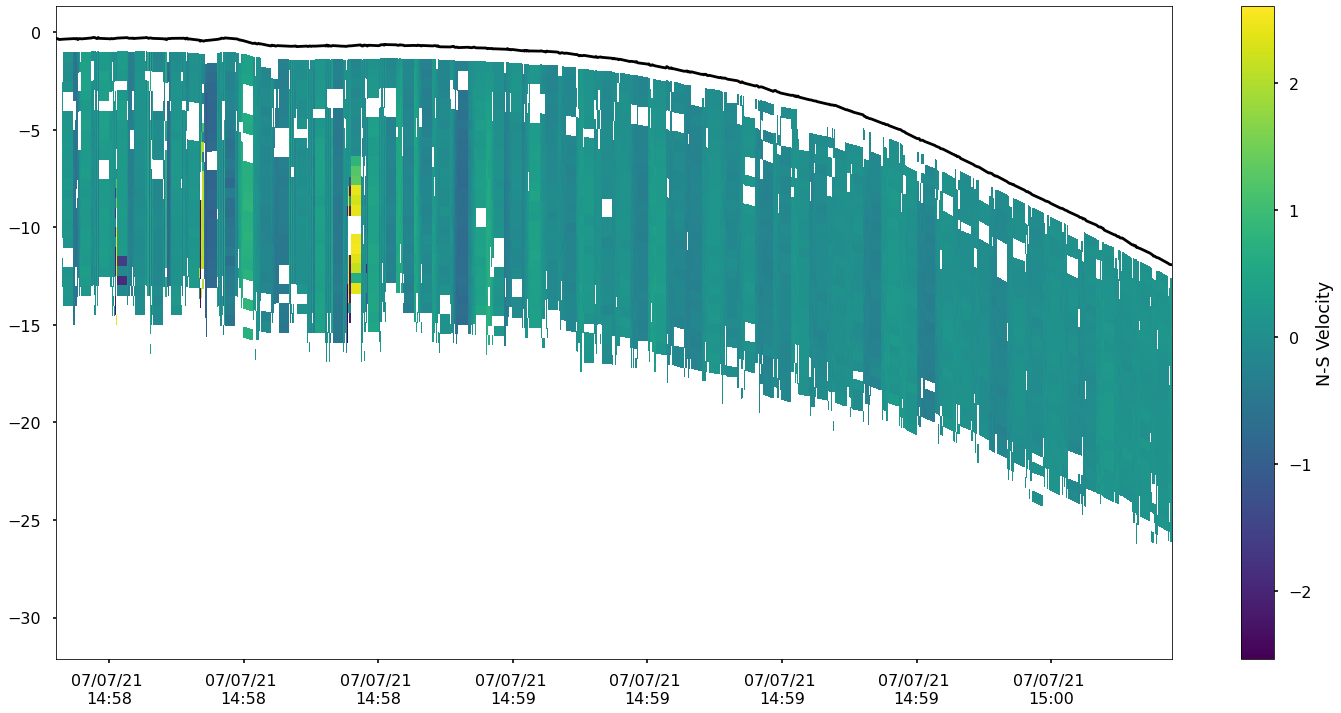

In [29]:
[x,y]=np.meshgrid(subset_ad2cp['time'],subset_ad2cp['VelocityRange'])
[bdepth,bbins]=np.meshgrid(subset_ad2cp['Pressure'],subset_ad2cp['VelocityRange'])

by=bdepth+bbins

start_ind = 0
end_ind   = 500

fig = plt.figure(figsize=(25,12))
plt.pcolormesh(x[:,start_ind:end_ind],-by[:,start_ind:end_ind],subset_ad2cp['VVelocity'][:,start_ind:end_ind])
plt.plot(subset_ad2cp['time'][start_ind:end_ind],-subset_ad2cp['Pressure'][start_ind:end_ind],'k')
plt.colorbar(label='N-S Velocity')
plt.gca().xaxis.set_major_formatter(myFmtlong)

In [30]:
subset_ad2cp = qaqc_post_coord_transform(subset_ad2cp, high_velocity_threshold=0.5, surface_depth_to_filter = 5)

/tmp/ipykernel_34270/2592399090.py:10: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(x[:,start_ind:end_ind],-by[:,start_ind:end_ind],subset_ad2cp['VVelocity'][:,start_ind:end_ind])


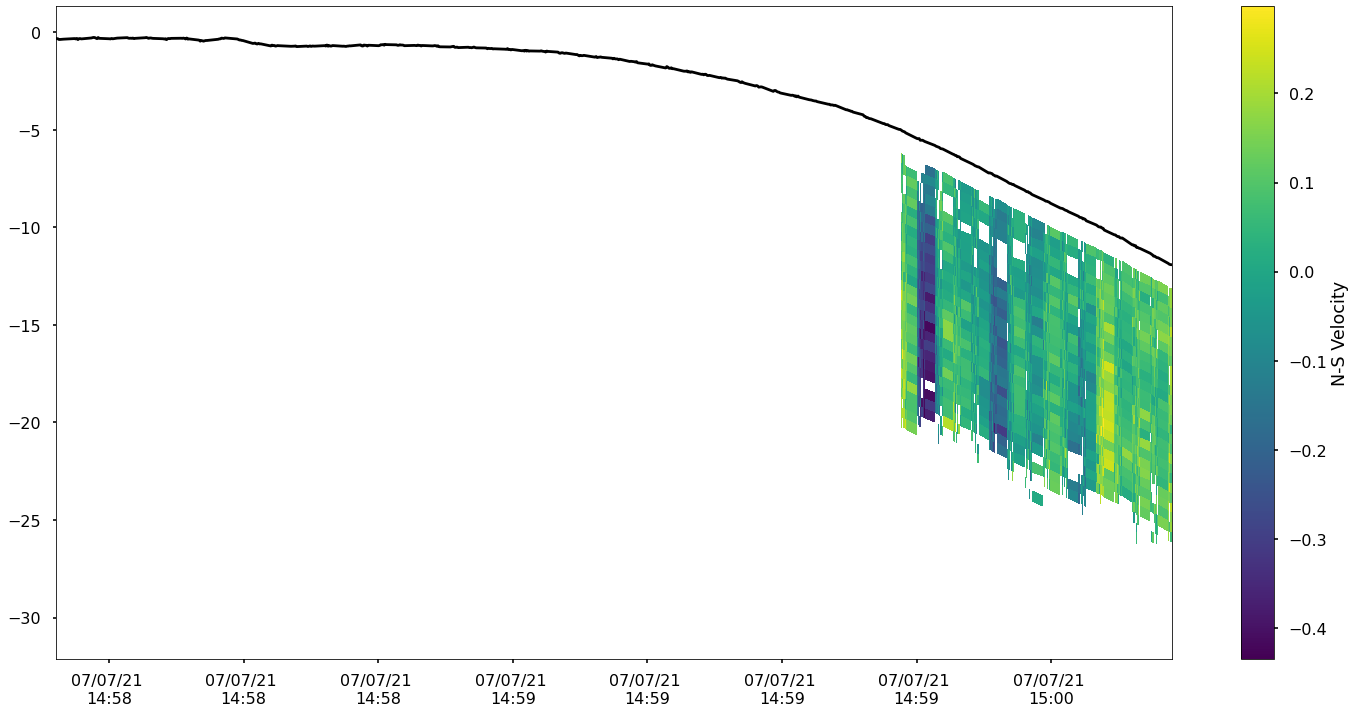

In [31]:
[x,y]=np.meshgrid(subset_ad2cp['time'],subset_ad2cp['VelocityRange'])
[bdepth,bbins]=np.meshgrid(subset_ad2cp['Pressure'],subset_ad2cp['VelocityRange'])

by=bdepth+bbins

start_ind = 0
end_ind   = 500

fig = plt.figure(figsize=(25,12))
plt.pcolormesh(x[:,start_ind:end_ind],-by[:,start_ind:end_ind],subset_ad2cp['VVelocity'][:,start_ind:end_ind])
plt.plot(subset_ad2cp['time'][start_ind:end_ind],-subset_ad2cp['Pressure'][start_ind:end_ind],'k')
plt.colorbar(label='N-S Velocity')
plt.gca().xaxis.set_major_formatter(myFmtlong)

## Processing Step 9: Run the inversion!

In [ ]:
start_time = time.time()

U=subset_ad2cp.UVelocity.values
V=subset_ad2cp.VVelocity.values
dz=10
u_daverage=vx
v_daverage=vy
bins = subset_ad2cp['VelocityRange'].values
depth = subset_ad2cp['Pressure'].values




## Feb-2021 jgradone@marine.rutgers.edu Initial
## Jul-2021 jgradone@marine.rutgers.edu Updates for constraints
## Jun-2022 jgradone@marine.rutgers.edu Corrected dimensions and indexing of G matrix

## Purpose: Take velocity measurements from glider mounted ADCP and compute
# shear profiles

## Outputs:
# O_ls is the ocean velocity profile
# G_ls is the glider velocity profile
# bin_new are the bin centers for the point in the profiles

## Inputs:
# dz is desired vertical resolution, should not be smaller than bin length
# U is measured east-west velocities from ADCP
# V is measured north-south velocities from ADCP
# bins is the bin depths for the U and V measurements
# uv_daverage is depth averaged velocity (Set to 0 for real-time)



#########################################################################        
## This determines the percentage of observations that are NaN in a row (bin)
# nanind = np.sum(np.isnan(U),axis=1)/U.shape[1]
# if len(np.where(nanind==1)[0])>0:
#     U = U[0:np.argmax(nanind==1),:]
#     V = V[0:np.argmax(nanind==1),:]
#     bins = bins[0:np.argmax(nanind==1)]
## Throw out all the data below the first row (bin) with all NaN


## This step effectively makes the computation faster because it reduces the size of the matrix
## This is even being super conservative because the drop off in good data is large. For example,
## the rows (bins) immediately shallower than the first row (bin) of all NaN is ~95% NaN.
## Maybe revisit this threshold.

## Do the same thing with individual ensembles. Note: need to remove the corresponding
## ensemble pressure reading to ensure correction dimensions and values.
nanind = np.where((np.sum(np.isnan(U),axis=0)/U.shape[0]) == 1)[0]
if len(np.where(nanind==1)[0])>0:
    U = np.delete(U,nanind,axis=1)
    V = np.delete(V,nanind,axis=1)
    depth = np.delete(depth,nanind)
##########################################################################        


##########################################################################        
# Take difference between bin lengths for bin size [m]
bin_size = np.diff(bins)[0]
bin_num = len(bins)
# This creates a grid of the ACTUAL depths of the ADCP bins by adding the
# depths of the ADCP bins to the actual depth of the instrument
[bdepth,bbins]=np.meshgrid(depth,bins)
bin_depth = bdepth+bbins  
Z = bin_depth
# Calculate the maximum depth of glider which is different than maximum ADCP bin depth
ZmM = np.nanmax(depth)
##########################################################################        


##########################################################################        
# Set knowns from Equations 19 from Visbeck (2002) page 800
# Maximum number of observations (nd) is given by the number of velocity
# estimates per ping (nbin) times the number of profiles per cast (nt)
nbin = U.shape[0]  # number of programmed ADCP bins per individual profile
nt   = U.shape[1]  # number of individual velocity profiles
nd   = nbin*nt      # G dimension (1) 

# Define the edges of the bins
bin_edges = np.arange(0,math.floor(np.max(bin_depth)),dz).tolist()

# Check that each bin has data in it
bin_count = np.empty(len(bin_edges)-1) # Preallocate memory
bin_count[:] = np.NaN

for k in np.arange(len(bin_edges))[:-1]:
    # Create index of depth values that fall inside the bin edges
    ii = np.where((bin_depth > bin_edges[k]) & (bin_depth < bin_edges[k+1]))
    bin_count[k] = len(bin_depth[ii])
    ii = []

# Create list of bin centers    
bin_new = [x+dz/2 for x in bin_edges[:-1]]
##########################################################################        


##########################################################################        
# Calculate which FINAL solution bin is deeper than the maximum depth of the glider
# This is done so that the depth averaged velocity constraint is only applied to bins shallower than this depth
depth_ind = len(np.where(bin_new>ZmM)[0])
# Chop off the top of profile if no data
ind = np.argmax(bin_count > 0) # Stops at first index greater than 0
bin_new = bin_new[ind:]        # Removes all bins above first with data
z1 = bin_new[0]                # Depth of center of first bin with data
##########################################################################        


##########################################################################        
# Create and populate G
nz = len(bin_new)  # number of ocean velocities desired in output profile
nm = nt + nz       # G dimension (2), number of unknowns
# Let's build the corresponding coefficient matrix G 
G = scipy.sparse.lil_matrix((nd, nm), dtype=float)

# Indexing of the G matrix was taken from Todd et al. 2012
for ii in np.arange(0,nt):           # Number of ADCP ensembles per segment
    for jj in np.arange(0,nbin):     # Number of measured bins per ensemble 
                
        # Uctd part of matrix
        G[(nbin*(ii))+jj,ii] = -1
        # This will fill in the Uocean part of the matrix. It loops through
        # all Z members and places them in the proper location in the G matrix
        # Find the difference between all bin centers and the current Z value        
        dx = abs(bin_new-Z[jj,ii])
        # Find the minimum of these differences
        minx = np.nanmin(dx)
        # Finds bin_new index of the first match of Z and bin_new    
        idx = np.argmin(dx-minx)
        
        # Uocean part of matrix
        G[(nbin*(ii))+jj,(nt)+idx] = 1
        
        
        del dx, minx, idx
        
##########################################################################        
# Reshape U and V into the format of the d column vector
d_u = U.flatten(order='C')
d_v = V.flatten(order='C')

##########################################################################
## This chunk of code containts the constraints for depth averaged currents

# Need to calculate C (Todd et al. 2017) based on our inputs 
# This creates a row that has the same # of columns as G. The elements
# of the row follow the trapezoid rule which is used because of the
# extension of the first bin with data to the surface. 

# ## Need to sort out the number of columns in the constraint. The last nz columns are the final ocean velocities
# ## so I need to make sure the constraint is only applied to the final ocean velocity bins that the glider dives through
constraint = np.concatenate(([np.zeros(nt)], [0], [np.tile(dz,nz-2)], [0]), axis=None)

# Ensure the L^2 norm of the constraint equation is unity
constraint_norm = np.linalg.norm(constraint/ZmM)
C = 1/constraint_norm
constraint_normalized = (C/ZmM)*constraint ## This is now equal to 1 (unity)
# Build Gstar and add weight from todd 2017
## Some smarts would be to calculate signal to noise ratio first
wDAC = 5
Gstar = scipy.sparse.vstack((G,wDAC*constraint_normalized), dtype=float)


# Add the constraint for the depth averaged velocity from Todd et al. (2017)
du = np.concatenate(([d_u],[wDAC*C*u_daverage]), axis=None)
dv = np.concatenate(([d_v],[wDAC*C*v_daverage]), axis=None)

# du = np.concatenate(([d_u],[dz*len(bin_new)*u_daverage]), axis=None)
# dv = np.concatenate(([d_v],[dz*len(bin_new)*v_daverage]), axis=None)
d = np.array(list(map(complex,du, dv)))


##########################################################################        
## Smoothness constraint
wSmoothness = 5 # weight from todd 2017
## Add a vector of zerosm the length of nz, twice to the bottom of the data column vector
d = np.concatenate(([d],[np.zeros(nz)],[np.zeros(nz)]), axis=None)

## Constraint on smoothing Uocean side of matrix
smoothing_matrix_Uocean = scipy.sparse.diags([[-1],[2],[-1]], [-1,0,1], shape=(nz,nz))
smoothing_matrix1 = scipy.sparse.hstack((np.zeros((nz,nt)),smoothing_matrix_Uocean), dtype=float)
## Constraint on smoothing Uglider side of matrix
smoothing_matrix_Uglider = scipy.sparse.diags([[-1],[2],[-1]], [-1,0,1], shape=(nz,nt))
smoothing_matrix2 = scipy.sparse.hstack((smoothing_matrix_Uglider,np.zeros((nz,nz))), dtype=float)
Gstar = scipy.sparse.vstack((Gstar,wSmoothness*smoothing_matrix1,wSmoothness*smoothing_matrix2), dtype=float)


##########################################################################        
#### THIS removes all NaN elements of d AND Gstar so the inversion doesn't blow up with NaNs
ind2 = np.where(np.isnan(d)==True)[0]
d = np.delete(d,ind2)

def delete_rows_csr(mat, indices):
    """
    Remove the rows denoted by ``indices`` form the CSR sparse matrix ``mat``.
    """
    if not isinstance(mat, scipy.sparse.csr_matrix):
        raise ValueError("works only for CSR format -- use .tocsr() first")
    indices = list(indices)
    mask = np.ones(mat.shape[0], dtype=bool)
    mask[indices] = False
    return mat[mask]

Gstar = delete_rows_csr(Gstar.tocsr().copy(),ind2)

#########################################################################        
# Test adding depth for tracking bin location
Z_filt = Z.flatten(order='C')
Z_filt = np.delete(Z_filt,ind2)
Z_filt = np.concatenate(([Z_filt],[0]), axis=None)


## Run the Least-Squares Inversion!
x, istop, itn, normr,r2norm,anorm,acond,arnorm,xnorm, var= lsqr(Gstar, d, calc_var=True)

O_ls = x[nt:]
G_ls = x[0:nt] 
##########################################################################        

print("My program took", time.time() - start_time, "to run")


## Testing

In [ ]:
rows_where_nt_not_equal_zero = np.where(Gstar.tocsr()[:,nt+50].toarray()==1)[0]

Z_filt2 = Z_filt
Z_filt2[rows_where_nt_not_equal_zero] = np.NaN

In [ ]:
plt.plot(Z_filt2,'.',color='tab:blue')
plt.plot(Z_filt,'.',color='tab:orange')
plt.gca().invert_yaxis()

In [68]:
np.sum(np.isnan(d[rows_where_nt_not_equal_zero])==False)

1463

(array([ 9154., 14914., 17832., 14424.,  9660.,  7724.,  5875.,  3809.,
         3895.,  3933.,  3863.,  3434.,  3330.,  2758.,  2741.,  2485.,
         2476.,  2491.,  2557.,  2357.,  2245.,  2295.,  1867.,  1666.,
         1558.,  1439.,  1236.,  1211.,  1090.,  1121.,  1106.,  1078.,
         1077.,  1135.,  1081.,  1140.,  1185.,  1156.,  1212.,  1364.,
         1442.,  1361.,  1372.,  1379.,  1397.,  1412.,  1389.,  1398.,
         1453.,   680.,   778.,  1503.,  1235.,  1372.,  1416.,  1299.,
         1169.,  1074.,  1139.,  1294.,  1189.,  1209.,  1106.,  1160.,
         1148.,  1192.,  1161.,  1160.,  1129.,  1047.,  1065.,  1053.,
         1018.,   911.,   955.,   924.,   860.]),
 array([ 10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100., 110.,
        120., 130., 140., 150., 160., 170., 180., 190., 200., 210., 220.,
        230., 240., 250., 260., 270., 280., 290., 300., 310., 320., 330.,
        340., 350., 360., 370., 380., 390., 400., 410., 420., 430., 440.,
      

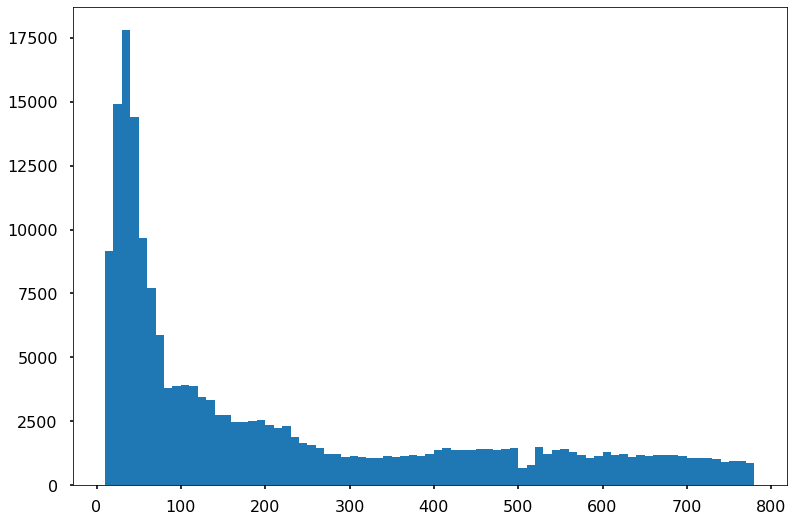

In [69]:
plt.hist(Z_filt,bins=bin_new)

In [70]:
# Ugood = np.where(np.isnan(U)==False)
# Vgood = np.where(np.isnan(V)==False)
# filtZu = np.sort(Z[Ugood])
# filtZv = np.sort(Z[Vgood])

# plt.hist(filtZu,bins=bin_new)


In [71]:
combined_UV = np.array(list(map(complex,U.flatten(order='C'),V.flatten(order='C'))))
nanfilt = np.where(np.isnan(combined_UV)==False)
combined_UV[nanfilt]

array([-0.29622677+0.16047104j, -0.2572266 +0.00180355j,
       -0.27971921+0.11459077j, ..., -0.24356086+0.00726565j,
       -0.03903996-0.08399801j, -0.16804531+0.0081024j ])

In [72]:
# plt.plot(np.real(O_ls),bin_new,label='u - velocity')
# plt.plot(np.imag(O_ls),bin_new,label='v - velocity')
# #plt.gca().invert_yaxis()
# plt.legend()
# plt.title('QC ON, 30% Correlation Cut Off \n dz={}'.format(dz))
# #plt.title('QC Off \n dz={}'.format(dz))

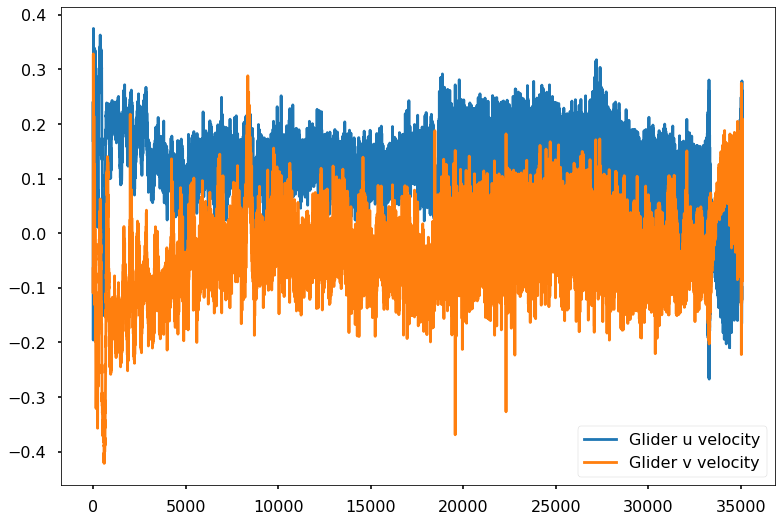

In [73]:
plt.plot(np.real(G_ls),label='Glider u velocity')
plt.plot(np.imag(G_ls),label='Glider v velocity')
plt.legend()

In [74]:
print('vx:',vx)
print('new caculated EW DAC:',np.nanmean(np.real(O_ls)))
print('vy:',vy)
print('new caculated NS DAC:',np.nanmean(np.imag(O_ls)))

vx: -0.0712351
new caculated EW DAC: -0.07192824916888431
vy: 0.0459152
new caculated NS DAC: 0.04597642755029253


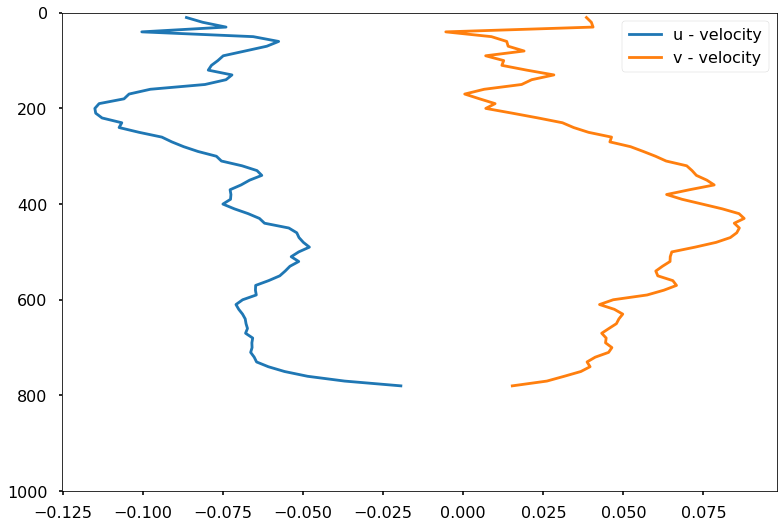

In [75]:
plt.plot(np.real(O_ls),bin_new,label='u - velocity')
plt.plot(np.imag(O_ls),bin_new,label='v - velocity')
plt.ylim(1000,0)
plt.legend()

In [49]:
# d_u_std = np.empty(nz)
# d_v_std = np.empty(nz)
# u_obs = np.empty(nz)
# v_obs = np.empty(nz)



# for x in np.arange(0,nz):
#     U_ind = np.where(G[:,nt+x].toarray()==1)[0]
#     d_u_std[x] = np.nanstd(d_u[U_ind])
#     d_v_std[x] = np.nanstd(d_u[U_ind])
    
#     u_obs[x] = len(d_u[U_ind])-np.sum(np.isnan(d_u[U_ind]))
#     v_obs[x] = len(d_v[U_ind])-np.sum(np.isnan(d_v[U_ind]))


    

In [50]:
# Uind = np.sum(np.isnan(U),axis=1)
# Vind = np.sum(np.isnan(V),axis=1)
# plt.plot(100*(Uind/nt),np.arange(1,nbin+1))
# plt.plot(100*(Uind/nt),np.arange(1,nbin+1),'.',markersize=20)
# plt.ylim((41,0))
# plt.ylabel('Bin #')
# plt.xlabel('% of Observations that are NaN')

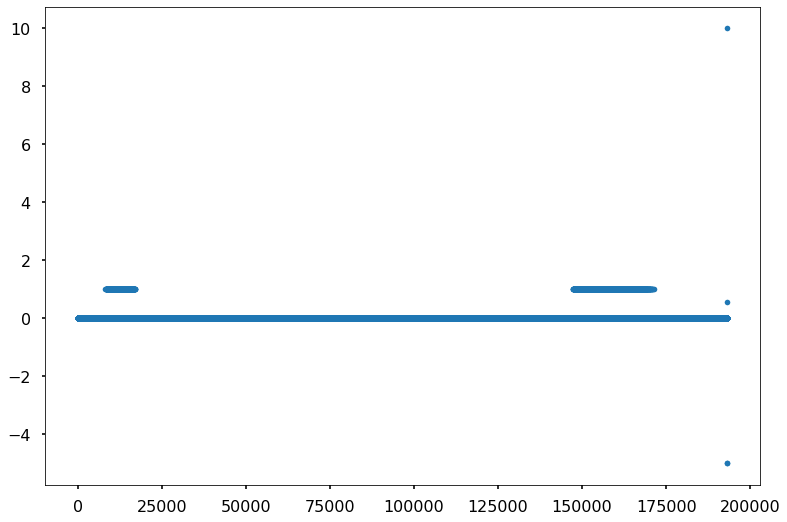

In [51]:
plt.plot(Gstar.tocsr()[:,nt+4].toarray().flatten(),'.')

## Quick shot at shear method

In [53]:
start_time = time.time()

U=subset_ad2cp.UVelocity.values
V=subset_ad2cp.VVelocity.values
dz=10
bins = subset_ad2cp['VelocityRange'].values
depth = subset_ad2cp['Pressure'].values




##########################################################################        
## This determines the percentage of observations that are NaN in a row (bin)
# nanind = np.sum(np.isnan(U),axis=1)/U.shape[1]
# ## Throw out all the data below the first row (bin) with all NaN
# U = U[0:np.argmax(nanind==1),:]
# V = V[0:np.argmax(nanind==1),:]
# bins = bins [0:np.argmax(nanind==1)]
## This step effectively makes the computation faster because it reduces the size of the matrix
## This is even being super conservative because the drop off in good data is large. For example,
## the rows (bins) immediately shallower than the first row (bin) of all NaN is ~95% NaN.
## Maybe revisit this threshold.

## Do the same thing with individual ensembles. Note: need to remove the corresponding
## ensemble pressure reading to ensure correction dimensions and values.
nanind = np.where((np.sum(np.isnan(U),axis=0)/U.shape[0]) == 1)[0]
U = np.delete(U,nanind,axis=1)
V = np.delete(V,nanind,axis=1)
depth = np.delete(depth,nanind)

##########################################################################        


##########################################################################        
# Take difference between bin lengths for bin size [m]
bin_size = np.diff(bins)[0]
bin_num = len(bins)
# This creates a grid of the ACTUAL depths of the ADCP bins by adding the
# depths of the ADCP bins to the actual depth of the instrument
[bdepth,bbins]=np.meshgrid(depth,bins)
bin_depth = bdepth+bbins  
Z = bin_depth
# Calculate the maximum depth of glider which is different than maximum ADCP bin depth
ZmM = np.nanmax(depth)
##########################################################################        


##########################################################################        
# Set knowns from Equations 19 from Visbeck (2002) page 800
# Maximum number of observations (nd) is given by the number of velocity
# estimates per ping (nbin) times the number of profiles per cast (nt)
nbin = U.shape[0]  # number of programmed ADCP bins per individual profile
nt   = U.shape[1]  # number of individual velocity profiles
nd   = nbin*nt      # G dimension (1) 

# Define the edges of the bins
bin_edges = np.arange(0,math.floor(np.max(bin_depth)),dz).tolist()

# Check that each bin has data in it
bin_count = np.empty(len(bin_edges)-1) # Preallocate memory
bin_count[:] = np.NaN

for k in np.arange(len(bin_edges))[:-1]:
    # Create index of depth values that fall inside the bin edges
    ii = np.where((bin_depth > bin_edges[k]) & (bin_depth < bin_edges[k+1]))
    bin_count[k] = len(bin_depth[ii])
    ii = []

# Create list of bin centers    
bin_new = [x+dz/2 for x in bin_edges[:-1]]
##########################################################################        


##########################################################################        
# Calculate which FINAL solution bin is deeper than the maximum depth of the glider
# This is done so that the depth averaged velocity constraint is only applied to bins shallower than this depth
depth_ind = len(np.where(bin_new>ZmM)[0])
# Chop off the top of profile if no data
ind = np.argmax(bin_count > 0) # Stops at first index greater than 0
bin_new = bin_new[ind:]        # Removes all bins above first with data
z1 = bin_new[0]                # Depth of center of first bin with data
##########################################################################        


##########################################################################        
## Preallocate for much much bigger than it really needs to be
U_mat = np.empty((len(bin_new),nt*nbin))
U_mat[:] = np.NaN
V_mat = np.empty((len(bin_new),nt*nbin))
V_mat[:] = np.NaN


for ii in np.arange(0,nt):           # Number of ADCP ensembles per segment
    for jj in np.arange(0,nbin):     # Number of measured bins per ensemble 
       
        # Find the difference between all bin centers and the current Z value        
        dx = abs(bin_new-Z[jj,ii])
        # Find the minimum of these differences
        minx = np.nanmin(dx)
        # Finds bin_new index of the first match of Z and bin_new    
        idx = np.argmin(dx-minx)
        ## Pull out this velocity
        U_mat[idx,(nbin*(ii))+jj] = U[jj,ii]
        V_mat[idx,(nbin*(ii))+jj] = V[jj,ii]

        
U_prof = np.nanmean(U_mat,axis=1)
V_prof = np.nanmean(V_mat,axis=1)   
U_prof_std = np.nanstd(U_mat,axis=1)
V_prof_std = np.nanstd(V_mat,axis=1)
dU_dZ = np.gradient(U_prof,dz)
dV_dZ = np.gradient(V_prof,dz)

# flip to integrate from bottom, then flip back
rel_V = np.flip(integrate.cumtrapz(np.flip(dV_dZ), dx=dz))
rel_U = np.flip(integrate.cumtrapz(np.flip(dU_dZ), dx=dz))


## Now add depth averaged current
vref = vy - np.nanmean(rel_V)
V_shear_method = rel_V + vref
uref = vx - np.nanmean(rel_U)
U_shear_method = rel_U + uref


print("My program took", time.time() - start_time, "to run")

/tmp/ipykernel_34270/1725801307.py:107: RuntimeWarning: Mean of empty slice
  U_prof = np.nanmean(U_mat,axis=1)
/tmp/ipykernel_34270/1725801307.py:108: RuntimeWarning: Mean of empty slice
  V_prof = np.nanmean(V_mat,axis=1)
/projects/dmcs_1/sw/packages/xroms/py38/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


My program took 26.10553216934204 to run


/tmp/ipykernel_34270/1725801307.py:120: RuntimeWarning: Mean of empty slice
  vref = vy - np.nanmean(rel_V)
/tmp/ipykernel_34270/1725801307.py:122: RuntimeWarning: Mean of empty slice
  uref = vx - np.nanmean(rel_U)


In [54]:
print('vx:',vx)
print('Shear Method Caculated EW DAC:',np.nanmean(U_shear_method))
print('vy:',vy)
print('Shear Method Caculated NS DAC:',np.nanmean(V_shear_method))

vx: -0.0712351
Shear Method Caculated EW DAC: nan
vy: 0.0459152
Shear Method Caculated NS DAC: nan


/tmp/ipykernel_34270/1021400797.py:2: RuntimeWarning: Mean of empty slice
  print('Shear Method Caculated EW DAC:',np.nanmean(U_shear_method))
/tmp/ipykernel_34270/1021400797.py:4: RuntimeWarning: Mean of empty slice
  print('Shear Method Caculated NS DAC:',np.nanmean(V_shear_method))


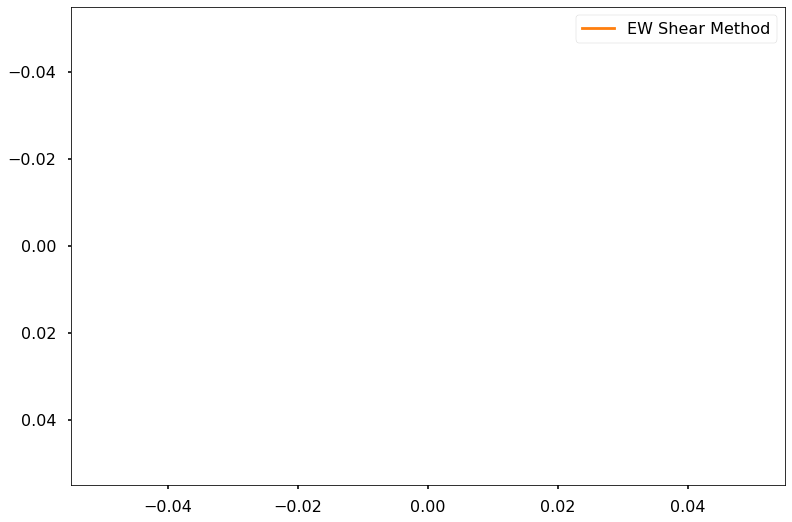

In [55]:
plt.fill_betweenx(bin_new[0:-1], U_shear_method-U_prof_std[0:-1], U_shear_method+U_prof_std[0:-1],alpha=0.2,color='tab:orange')
plt.plot(U_shear_method,bin_new[0:-1], label='EW Shear Method',color='tab:orange')
plt.gca().invert_yaxis()
plt.legend()


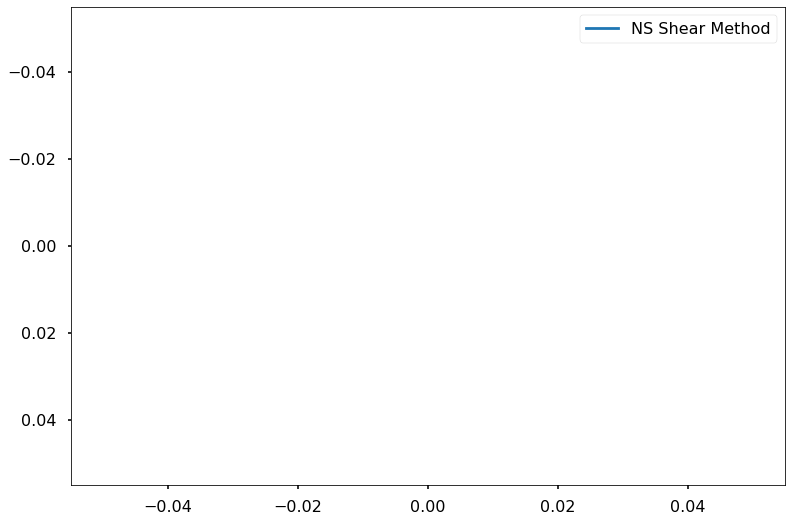

In [56]:
plt.fill_betweenx(bin_new[0:-1], V_shear_method-V_prof_std[0:-1], V_shear_method+V_prof_std[0:-1],alpha=0.2,color='tab:blue')
plt.plot(V_shear_method,bin_new[0:-1], label='NS Shear Method',color='tab:blue')
plt.gca().invert_yaxis()
plt.legend()



## Original Inversion

In [57]:
#Now ready for inversion!
O_ls2, G_ls2, bin_new2 = inversion(U=subset_ad2cp.UVelocity.transpose().values,V=subset_ad2cp.VVelocity.transpose().values,H=1000,dz=20,u_daverage=vx,v_daverage=vy,bins = subset_ad2cp['VelocityRange'], depth = subset_ad2cp['Pressure'])

In [58]:
print('vx:',vx)
print('new caculated EW DAC:',np.nanmean(np.real(O_ls)))
print('old caculated EW DAC:',np.nanmean(np.real(O_ls2)))

vx: -0.0712351
new caculated EW DAC: -0.07086626893712417
old caculated EW DAC: -0.09502040845731591


In [59]:
print('vy:',vy)
print('new caculated NS DAC:',np.nanmean(np.imag(O_ls)))
print('old caculated NS DAC:',np.nanmean(np.imag(O_ls2)))

vy: 0.0459152
new caculated NS DAC: 0.04540857342290863
old caculated NS DAC: 0.06098424905036307


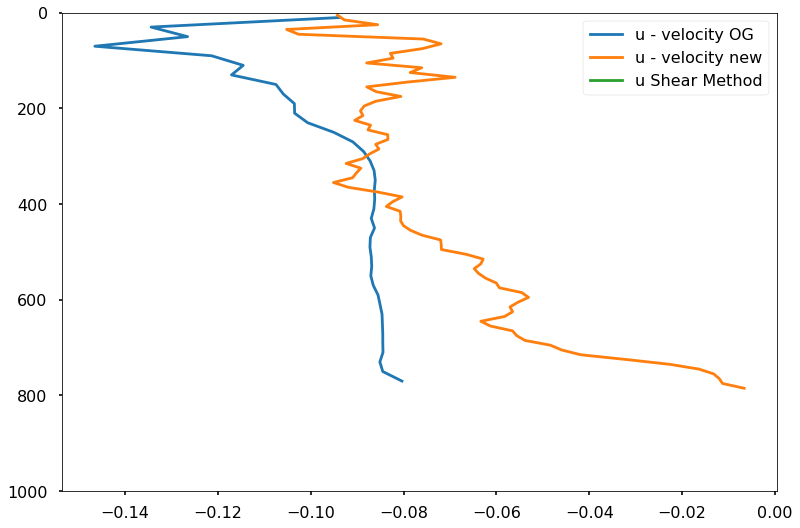

In [63]:
plt.plot(np.real(O_ls2),bin_new2,label='u - velocity OG')
plt.plot(np.real(O_ls),bin_new,label='u - velocity new')
plt.plot(U_shear_method,bin_new[0:-1], label='u Shear Method')
plt.ylim(1000,0)
plt.legend()

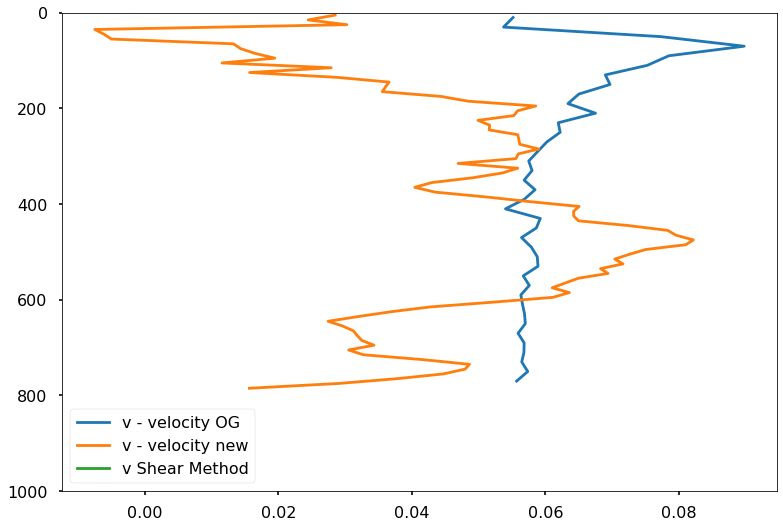

In [64]:
plt.plot(np.imag(O_ls2),bin_new2,label='v - velocity OG')
plt.plot(np.imag(O_ls),bin_new,label='v - velocity new')
plt.plot(V_shear_method,bin_new[0:-1], label='v Shear Method')
plt.ylim(1000,0)
plt.legend()

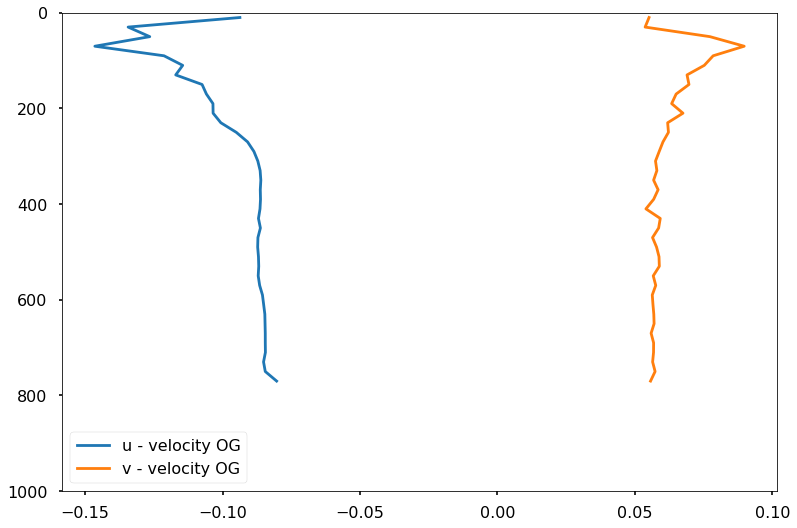

In [62]:
plt.plot(np.real(O_ls2),bin_new2,label='u - velocity OG')
plt.plot(np.imag(O_ls2),bin_new2,label='v - velocity OG')
plt.ylim(1000,0)
plt.legend()

# Loess Filter Testing

In [ ]:
U=subset_ad2cp.UVelocity.values
V=subset_ad2cp.VVelocity.values
bins = subset_ad2cp['VelocityRange'].values
depth = subset_ad2cp['Pressure'].values


##########################################################################        
# Take difference between bin lengths for bin size [m]
bin_size = np.diff(bins)[0]
bin_num = len(bins)
# This creates a grid of the ACTUAL depths of the ADCP bins by adding the
# depths of the ADCP bins to the actual depth of the instrument
[bdepth,bbins]=np.meshgrid(depth,bins)
bin_depth = bdepth+bbins  
Z = bin_depth

##########################################################################        
# Reshape U and V and Z
flatu = U.flatten(order='F')
flatv = V.flatten(order='F')
flatz = Z.flatten(order='F')
# Make a dataframe for easy sorting and filtering
flatd = {'depth': flatz, 'u': flatu, 'v': flatv}
flat_df = pd.DataFrame(data=flatd)
flat_df = flat_df.sort_values(by=['depth'])
flat_df = flat_df.dropna(subset=['u', 'v'], how='all')

##########################################################################        
# Define the edges of the final velocity profile bins
bin_edges = np.arange(0,math.ceil(np.max(flat_df.depth)),dz).tolist()
# Create list of bin centers    
bin_new = [x+dz/2 for x in bin_edges[:-1]]
##########################################################################        


plt.plot(flat_df.v,flat_df.depth,label='NS Velocity')
plt.plot(flat_df.u,flat_df.depth,label='EW Velocity')
plt.gca().invert_yaxis()
plt.legend()

In [ ]:
import loess

# Testing and Data Exploration

### Checking on pitch vattery-dependent magnetic heading correction

In [ ]:
# # x=28
# # subsetgdf = gdf[(gdf.time >= start_times[x]) & (gdf.time <= end_times[x])]
# # ad2cp_time_ind = np.where((tot_ad2cp.time >= start_times2[x]) & (tot_ad2cp.time <= end_times2[x]))[0]
# # subset_ad2cp = tot_ad2cp.sel(time=tot_ad2cp.time[ad2cp_time_ind])


# fig,ax = plt.subplots()

# ln1 = ax.plot(subset_ad2cp.Heading.values,label='AD2CP Heading')
# ax2=ax.twiny()
# ln2 = ax2.plot(np.rad2deg(subsetgdf.m_heading),'.',color='orange',label='Glider Heading')
# ax.set_ylabel('Heading [deg]')
# ax3=ax.twinx()
# ln3 = ax3.plot(subset_ad2cp.Pressure.values,color='black',label='Depth')
# ax3.invert_yaxis()
# ax3.set_ylabel('Depth [m]')
# lns = ln1+ln2+ln3
# labs = [l.get_label() for l in lns]
# ax.legend(lns, labs, loc='lower left',frameon=False)

### Sweet, data looks good.